In [1]:
import datetime
import itertools
import mthree
import numpy as np
import os
from qiskit import Aer, IBMQ
from qiskit.providers.ibmq import IBMQBackend, IBMQJob
from analysis import KitaevHamiltonianAnalysis
from experiment import KitaevHamiltonianExperiment

In [2]:
# get backend
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
# hardware_backend = provider.get_backend('ibmq_lima')
simulator_backend = Aer.get_backend("statevector_simulator")

In [3]:
# set parameters

# backend
backend = simulator_backend

# Hamiltonian parameters
n_modes = 3
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=10)
occupied_orbitals_list = [(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]

# qubits
# TODO choose qubits that minimize error rate
qubits = [0, 1, 2]

# number of shots
shots = 10000

# number of shots for measurement error calibration
readout_calibration_shots = 50000

# experiment id used for saving data
experiment_id = f'{datetime.datetime.now().isoformat()}_{backend.name()}'

In [4]:
# schedule readout calibration
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=shots)
filename = f'data/{experiment_id}/readout_calibration.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
mit.cals_to_file(filename)

# schedule experiment jobs
experiment = KitaevHamiltonianExperiment(
    experiment_id=experiment_id,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    backend=backend,
)
data = experiment.run(shots=shots)

In [5]:
# wait for exeriment results
data.block_for_results()

<ExperimentData[KitaevHamiltonianExperiment], backend: statevector_simulator, status: ExperimentStatus.DONE, experiment_id: 97c43944-25d6-4601-bcf6-32b99922f558>

In [6]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import matplotlib.pyplot as plt
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
converter = QubitConverter(mapper=JordanWignerMapper())

# run analysis
analysis = KitaevHamiltonianAnalysis()
analysis.run(data)

<ExperimentData[KitaevHamiltonianExperiment], backend: statevector_simulator, status: ExperimentStatus.POST_PROCESSING, experiment_id: 97c43944-25d6-4601-bcf6-32b99922f558>

/home/kjs/projects/qiskit-research/mzm-generation/mzm_generation.py:101: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


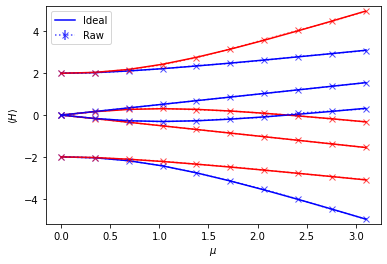

In [7]:
# plot energy
energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value

# raw data only
fig, ax = plt.subplots()
for occupied_orbitals, series in energy_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values, series, label=label, color=color
    )
for occupied_orbitals, series in energy_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    energies, stddevs = zip(*series)
    ax.errorbar(
        experiment.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.set_ylim(-5.2, 5.2)
ax.legend()

data.add_figures(fig, 'energy_raw', overwrite=True)
plt.show()

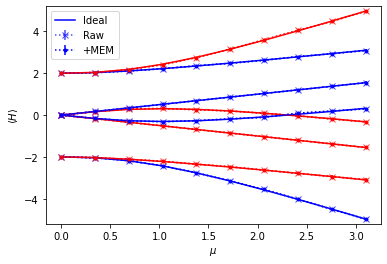

In [8]:
# raw data and readout error mitigated data
fig, ax = plt.subplots()
for occupied_orbitals, series in energy_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values, series, label=label, color=color
    )
for occupied_orbitals, series in energy_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    energies, stddevs = zip(*series)
    ax.errorbar(
        experiment.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, series in energy_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    energies, stddevs = zip(*series)
    ax.errorbar(
        experiment.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.set_ylim(-5.2, 5.2)
ax.legend()

data.add_figures(fig, 'energy_raw_mem', overwrite=True)
plt.show()

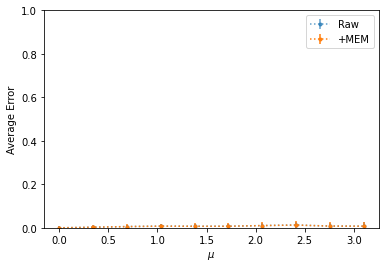

In [9]:
# plot average error in energy
fig, ax = plt.subplots()

energy_error_raw = np.zeros(len(experiment.chemical_potential_values))
energy_error_stddev_raw = np.zeros(len(experiment.chemical_potential_values))
energy_error_mem = np.zeros(len(experiment.chemical_potential_values))
energy_error_stddev_mem = np.zeros(len(experiment.chemical_potential_values))
for occupied_orbitals in experiment.occupied_orbitals_list:
    exact = np.array(energy_exact[occupied_orbitals])

    raw, raw_stddev = zip(*energy_raw[occupied_orbitals])
    raw = np.array(raw)
    energy_error_raw += np.abs(raw - exact)
    energy_error_stddev_raw += np.array(raw_stddev) ** 2

    mem, mem_stddev = zip(*energy_mem[occupied_orbitals])
    mem = np.array(mem)
    energy_error_mem += np.abs(mem - exact)
    energy_error_stddev_mem += np.array(mem_stddev) ** 2
energy_error_raw /= 2 ** n_modes
energy_error_stddev_raw = np.sqrt(energy_error_stddev_raw) / 2 ** n_modes
energy_error_mem /= 2 ** n_modes
energy_error_stddev_mem = np.sqrt(energy_error_stddev_mem) / 2 ** n_modes

ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
    alpha=0.7,
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_ylim(0.0, 1.0)
ax.legend()

data.add_figures(fig, 'energy_error_raw_mem', overwrite=True)
plt.show()

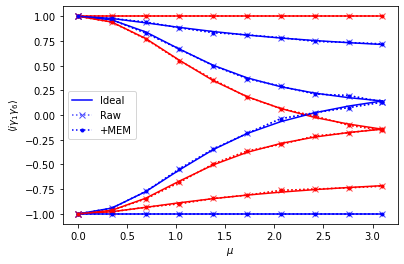

In [10]:
# plot edge correlation
edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value

fig, ax = plt.subplots()
for occupied_orbitals, series in edge_correlation_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(experiment.chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in edge_correlation_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values,
        series,
        "x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, series in edge_correlation_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values, series, ".:", label=label, color=color
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle i \gamma_1 \gamma_6 \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'edge_correlation_raw_mem', overwrite=True)
plt.show()

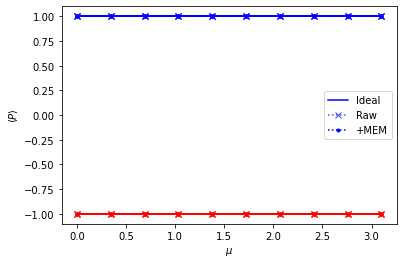

In [11]:
# plot parity
parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
fig, ax = plt.subplots()
for occupied_orbitals, series in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(experiment.chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values,
        series,
        "x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, series in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        experiment.chemical_potential_values, series, ".:", label=label, color=color
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity_raw_mem', overwrite=True)
plt.show()

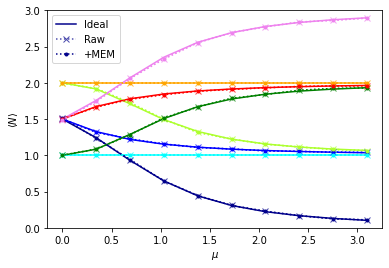

In [12]:
# plot number
number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value

fig, ax = plt.subplots()
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
}
for occupied_orbitals, series in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        experiment.chemical_potential_values,
        series,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, series in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.plot(
        experiment.chemical_potential_values,
        series,
        "x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, series in number_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    ax.plot(
        experiment.chemical_potential_values,
        series,
        ".:",
        label=label,
        color=colors[occupied_orbitals],
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.set_ylim(0, 3)
ax.legend()

data.add_figures(fig, 'number_raw_mem', overwrite=True)
plt.show()